In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
%matplotlib inline
import matplotlib.pyplot as plt
import os
import math
import random

import warnings
warnings.simplefilter('ignore')

/home/steich/NF_Prize_Data/nf_prize_env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
log_dir = '/home/steich/NF_Prize_Data/log'

In [3]:
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

Basic idea to be explored here: the main distinguishing feature of a movie is the people involved in its' making.  If we have crew/cast embeddings we can use those (as a sum-of, or similar to making a document or paragraph vector) to make meaningful movie embeddings.

Cast/Crew embeddings can be made using IMDB data. A Bag of Words model allows us to create embeddings by predicting, for each movie, other cast and crew that worked on that movie. 

Sources:
* https://github.com/tensorflow/tensorflow/blob/r1.6/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
* https://www.tensorflow.org/tutorials/word2vec
* https://cs.stanford.edu/~quocle/paragraph_vector.pdf
* https://arxiv.org/pdf/1301.3781.pdf
* https://arxiv.org/pdf/1507.07998.pdf
* https://www.imdb.com/interfaces/


In [4]:
#First, get the data out of the .tsv files

#using the name.basics.tsv file we can create a 
#cast/crew id -> name dictionary
id_to_name_dict = {}
name_count = 0
credits = 0
with open('/home/steich/NF_Prize_Data/data/imdb/name.basics.tsv') as iFile:
    for line in iFile:
        fields = line.split('\t')
        id_to_name_dict[fields[0]] = [fields[1], name_count, credits]

#we can also create a movie_id -> name dictionary
id_to_movie_dict = {}
movie_count = 0
with open('data/imdb/title.basics.tsv') as iFile:
    for line in iFile:
        fields = line.split('\t')
        id_to_movie_dict[fields[0]] = [fields[2], movie_count]
        movie_count += 1

In [5]:
#now we need to build a dictionary of people involved in each movie

#title.principals.tsv has lead/billed actors and directors
#title.crew.tsv has other notable figures who worked on each movie
# - it looks like there is some overlap
#we want a dict like this: movie_dict["movie_id"]=["person_id1", ...]
movie_dict = {}

#with open('data/imdb/title.crew.tsv') as crewFile:
#    for line in crewFile:
#        fields = line.split('\t')
#        directors = []
#        writers = []
#        if '\\' + 'N' not in fields[1]:
#            directors = fields[1].split(',')
#        if '\\' + 'N' not in fields[2]:
#            writers = fields[2].split(',')
#        movie_dict[fields[0]] = directors + writers
        
with open('/home/steich/NF_Prize_Data/data/imdb/title.principals.tsv') as prinFile:
    for line in prinFile:        
        fields = line.split('\t')
        if not movie_dict.get(fields[0]):
            movie_dict[fields[0]] = []
        if fields[2] not in movie_dict[fields[0]]:
            movie_dict[fields[0]].append(fields[2])
            if not id_to_name_dict.get(fields[2]): 
                #looks like there's some unknown/unnamed people
                id_to_name_dict[fields[2]] = ['UNK', name_count, 1]
            else:
                id_to_name_dict[fields[2]][2] += 1


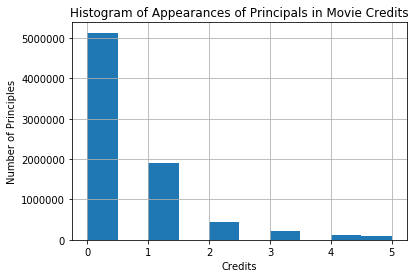

In [6]:
n, bins, patches = plt.hist([i[2] for i in id_to_name_dict.values()], range=(0,5))
plt.xlabel('Credits')
plt.ylabel('Number of Principles')
plt.title('Histogram of Appearances of Principals in Movie Credits')
plt.grid(True)
plt.show()

In [7]:
len([i[2] for i in id_to_name_dict.values() if i[2] > 3])

798403

In [8]:
temp_dict = {}
scalar_to_id_dict = {}
for i in id_to_name_dict:
    #get rid of the principles with no actual credits
    if id_to_name_dict[i][2] > 3:
        temp_dict[i] = id_to_name_dict[i]
del id_to_name_dict
id_to_name_dict = temp_dict
        
for index, key in enumerate(id_to_name_dict):
    #now that the chaff is removed, give the correct scalar identifier
    #reserve 0 as a blank/nobody slot
    id_to_name_dict[key][1] = index + 1
    #make the reverse dictionary
    scalar_to_id_dict[index] = key

name_count = len(id_to_name_dict)
  
temp_movie_dict = {}
for movie in movie_dict:
    tmp_p_list = []
    for principle in movie_dict[movie]:
        if id_to_name_dict.get(principle):
            tmp_p_list.append(principle)
    movie_dict[movie] = [p for p in tmp_p_list]
    if [p for p in movie_dict[movie] if id_to_name_dict[p][2] > 0]:
        temp_movie_dict[movie] = movie_dict[movie]
del movie_dict
movie_dict = temp_movie_dict

In [9]:
#since we want bag of words training, our input is a name scalar, 
#and our output is a list of the name scalars associted with that name
#on the production the batch was taken from

x_train = []
y_train = []

for movie in movie_dict:
    for person in movie_dict[movie]:
        y = id_to_name_dict[person][1]
        x = [id_to_name_dict[p][1] for p in movie_dict[movie] if p != person]
        #if len(x) < 9:
        #    x += [0 for i in range(9 - len(x))]
        x_train.append(x)
        y_train.append(y)


In [10]:
def nf_onehot_transformation_function(label, name_count):
    
    one_hot = np.zeros(name_count)
    one_hot[label] = 1
    return one_hot

In [11]:
def generate_batch(train_features, train_labels, batch_size, steps, name_count):
    
    batch_samples = np.zeros((batch_size, name_count))
    batch_labels = np.zeros((batch_size, name_count))
    index_list = list(range(len(train_labels)))
    random.shuffle(index_list)
    batch_count = 0
    step = 0
    
    while True:
        
        if step % steps == 0:
            index_list = list(range(len(train_labels)))
            random.shuffle(index_list)
        
        curr_index = index_list[-1]
        for i in train_features[curr_index]:
            
            if batch_count == 32:
                batch_count = 0
                step += 1
                yield (batch_samples, batch_labels)
            
            batch_labels[batch_count] = nf_onehot_transformation_function(train_labels[curr_index], name_count)
            batch_samples[batch_count] = nf_onehot_transformation_function(i, name_count)
            batch_count += 1
            
        index_list.pop()


In [12]:
name_count

798403

In [13]:
epochs = 100
batch_size = 32
embedding_size = 64
steps = 1000

import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

opt = keras.optimizers.SGD()

training_model = Sequential()
training_model.add(Dense(embedding_size, activation='linear', input_shape=(name_count,), name="Embedding_Layer"))
training_model.add(Dense(name_count, activation="softmax", name="Output_Layer"))

training_model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])
embedding_model = Model(inputs=training_model.input, outputs=training_model.get_layer("Embedding_Layer").output)
embedding_output = embedding_model.predict

print("Model Compiled")

Model Compiled


Using TensorFlow backend.


In [14]:
train_gen = generate_batch(x_train, y_train, batch_size, steps, name_count)
checkpointer = ModelCheckpoint(filepath='../models/Keras_Embedding_Softmax_128', verbose=1, save_best_only=True)
training_model.fit_generator(train_gen,
                    epochs=epochs,
                    steps_per_epoch=steps,
                    callbacks=[checkpointer]
                    )

Epoch 1/100
1000/1000 [==============================] - 418s 418ms/step - loss: 13.5865 - acc: 0.0030
Epoch 2/100
1000/1000 [==============================] - 348s 348ms/step - loss: 13.5863 - acc: 0.0000e+00
Epoch 3/100
  65/1000 [>.............................] - ETA: 18:55 - loss: 13.6029 - acc: 0.0000e+00

KeyboardInterrupt: 